In [15]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, fftfreq
from skimage.restoration import unwrap_phase


def PHI(P,X,Y):
    M = Y.shape[0]
    N = X.shape[1]
    arbitrary_additive_constant = 0
    PHI = np.where( X + Y != 0 ,P / (2*np.cos(np.pi*Y/M) + 2*np.cos(np.pi*X/N) - 4), arbitrary_additive_constant)
    return PHI


def mirror_reflect_data(wrapped_data):
    data_flip_vert = np.flip(wrapped_data,axis=1)
    extended_data = np.concatenate((wrapped_data,data_flip_vert[:,1::]),axis=1) # see definition in equation 3 of the paper; M<j<=2M implies we need such slice
    data_flip_horiz = np.flip(extended_data,axis=0)
    full_data = np.concatenate((data_flip_horiz[0:-1,:],extended_data),axis=0) # see definition in equation 3 of the paper; N<k<2N implies we need such slice

    if 0: 
        figure, ax = plt.subplots(1,3,dpi=200)
        ax[0].imshow(wrapped_data), ax[0].set_title('Wrapped')
        ax[1].imshow(data_flip_vert), ax[1].set_title("Flipped")    
        ax[2].imshow(extended_data)

        figure, ax = plt.subplots(1,2,dpi=200)
        ax[0].imshow(wrapped_data), ax[0].set_title('Wrapped')
        ax[1].imshow(full_data), ax[1].set_title("Full")    
        
    return full_data

def unwrap_LS(wrapped_data):

    extended_data = mirror_reflect_data(wrapped_data)

    dx = extended_data - np.roll(extended_data,-1,axis=1)
    dy = extended_data - np.roll(extended_data,1,axis=0)

    dx_shift = np.roll(dx,-1,axis=1)
    dy_shift = np.roll(dy,1,axis=0)
    rho = dx - dx_shift + dy - dy_shift

    if 0:
        figure, ax = plt.subplots(1,3,dpi=200)
        ax[0].imshow(dx), ax[0].set_title('DeltaX')
        ax[1].imshow(dy), ax[1].set_title("DeltaY")
        ax[2].imshow(rho)

    X = fftshift(fftfreq(rho.shape[1])) # spatial frequency
    Y = fftshift(fftfreq(rho.shape[0])) # spatial frequency
    X, Y = np.meshgrid(X,Y)

    rho_FT = fftshift(fft2(rho))
    phi_full = ifft2(fftshift(PHI(rho_FT,X,Y)))
    phi_full = np.abs(phi_full)
    phi = phi_full[phi_full.shape[0]//2::,0:phi_full.shape[1]//2+1]


    return phi

    
def calculate_phase_gradient(phase,direction):
    """ Axis convention:
    y-direction
    ^
    | 
    |___>  x-direction
    """
    if direction == 1:
        return np.roll(phase,1,axis=1)-phase
    if direction == 0:
        return np.roll(phase,-1,axis=0)-phase
        
def calculate_normalized_weight(phase,delta,eps0=0.01,p=0,direction=0):
    """
    Equation (38) and (39) of 'Minimum Lp-norm two-dimensional phase unwrapping' (https://doi.org/10.1364/JOSAA.13.001999)
    """
    if direction == 1:
        phase_gradient_x = calculate_phase_gradient(phase,direction)
        U = eps0 / ( np.abs(phase_gradient_x-delta)**(2-p) + eps0 ) 
        U[:,-1] = 0
        return U
    elif direction == 0:
        phase_gradient_y = calculate_phase_gradient(phase,direction)
        V = eps0 / ( np.abs(phase_gradient_y-delta)**(2-p) + eps0 )
        V[-1,:] = 0 
        return V


def calculate_wrapped_phase_difference(wrapped_phase,direction=0):
    """
    Equation (2) and (3) of 'Minimum Lp-norm two-dimensional phase unwrapping' (https://doi.org/10.1364/JOSAA.13.001999)
    """
    if direction == 1:
        f = calculate_phase_gradient(wrapped_phase,direction) 
        f[:,-1] = 0
        return f
    elif direction == 0:
        g = calculate_phase_gradient(wrapped_phase,direction) 
        g[:,-1] = 0
        return g

    
def modified_Laplacian_weighted_wrapped_phase_gradient(phase,wrapped_phase):
    """
    Equation (37) of 'Minimum Lp-norm two-dimensional phase unwrapping' (https://doi.org/10.1364/JOSAA.13.001999)
    
    """
    
    delta_x1 = calculate_wrapped_phase_difference(wrapped_phase,0)
    U1 = calculate_normalized_weight(phase,delta_x1,direction=0)
    
    delta_x2 = calculate_wrapped_phase_difference(np.roll(wrapped_phase,-1,axis=1),0) # check if internal shift is correct
    U2 = calculate_normalized_weight(np.roll(phase,-1,axis=1),delta_x2,direction=0)
    
    delta_y1 = calculate_wrapped_phase_difference(wrapped_phase,1)
    V1 = calculate_normalized_weight(phase,delta_y1,direction=1)
    
    delta_y2 = calculate_wrapped_phase_difference(np.roll(wrapped_phase,1,axis=0),1)
    V2 = calculate_normalized_weight(np.roll(phase,1,axis=0),delta_y2,direction=1)
    
    return delta_x1*U1 - delta_x2*U2 + delta_y1*V1 - delta_y2*V2
    
def modified_Laplacian_phase_gradient(phase,wrapped_phase):
    """
    Equation (37) of 'Minimum Lp-norm two-dimensional phase unwrapping' (https://doi.org/10.1364/JOSAA.13.001999)
    """

    delta_x1_phase = calculate_wrapped_phase_difference(phase,0)    
    delta_x1_wrapped = calculate_wrapped_phase_difference(wrapped_phase,0)
    U1 = calculate_normalized_weight(phase,delta_x1_wrapped,direction=0)
    
    delta_x2_phase = calculate_wrapped_phase_difference(np.roll(phase,-1,axis=1),0)    
    delta_x2_wrapped = calculate_wrapped_phase_difference(np.roll(wrapped_phase,-1,axis=1),0) # check if internal shift is correct
    U2 = calculate_normalized_weight(np.roll(phase,-1,axis=1),delta_x2_wrapped,direction=0)
    
    delta_y1_phase = calculate_wrapped_phase_difference(phase,0)    
    delta_y1_wrapped = calculate_wrapped_phase_difference(wrapped_phase,1)
    V1 = calculate_normalized_weight(phase,delta_y1_wrapped,direction=1)
    
    delta_y2_phase = calculate_wrapped_phase_difference(np.roll(phase,1,axis=0),1)    
    delta_y2_wrapped = calculate_wrapped_phase_difference(np.roll(wrapped_phase,1,axis=0),1)
    V2 = calculate_normalized_weight(np.roll(phase,1,axis=0),delta_y2_wrapped,direction=1) #CHECK
    
    return delta_x1_phase*U1 - delta_x2_phase*U2 + delta_y1_phase*V1 - delta_y2_phase*V2

def calculate_beta(r1,z1,r2,z2):
    return np.dot(r1.T,z1)/np.dot(r2.T,z2)

def calculate_alpha(wrapped_phase,p,r1,z1,original_shape):
    return np.dot(r1.T,z1)/ np.dot(p.T,modified_Laplacian_phase_gradient(np.reshape(p,original_shape),wrapped_phase).flatten())

def calculate_residual_wrapped_phase(phase,wrapped_phase):
    R = wrapped_phase - phase
    return wrap(R)

def wrap(x):
    return np.angle(np.exp(1j*x))

def calculate_residues(R):
    dy = wrap(np.roll(R,-1,axis=0) - R)
    dx = wrap(np.roll(R,1,axis=1) - R)
    dx2 = wrap( np.roll(R,(1,-1),axis=(1,0)) - np.roll(R,-1,axis=0) )
    dy2 = wrap( np.roll(R,(1,-1),axis=(1,0)) - np.roll(R,+1,axis=1) )    
    return dy + dx2 - dy2 - dx   # Equation (4) of 'Minimum Lp-norm two-dimensional phase unwrapping' (https://doi.org/10.1364/JOSAA.13.001999). I believe there is an error in the last sign in the paper. It is ++-+, should be ++--.

def min_Lp_norm_phase_unwrap(wrapped_phase,inner_iterations=100,outer_iterations=5):
    """ Minimun Lp-norm 2D phase unwrapping """
    phi_guess = np.ones_like(wrapped_phase)
    original_shape = phi_guess.shape

    phase = phi_guess
    for l in range(outer_iterations): # outer loop to update coefficients
        print(f"Outer iteration {l+1}/{outer_iterations}")
        if l >= outer_iterations: break

        phase = np.reshape(phase,wrapped_phase.shape)
        RWP = calculate_residual_wrapped_phase(phase,wrapped_phase)
        residues = calculate_residues(RWP)

        if residues.any != 0: # if residues exist:
            pass
        else:
            phase = phase + unwrap_LS(RWP) # equation 44, 'Minimum Lp-norm two-dimensional phase unwrapping' https://doi.org/10.1364/JOSAA.13.001999
            break

        C = modified_Laplacian_weighted_wrapped_phase_gradient(phase,wrapped_phase)
        Qphi = modified_Laplacian_phase_gradient(phase,wrapped_phase)
        
        residual  = C - Qphi
        z = unwrap_LS(residual).flatten() # solve P*z = r (step 2, Algorithm WLS, 'Minimum Lp-norm two-dimensional phase unwrapping' https://doi.org/10.1364/JOSAA.13.001999)

        residual = residual.flatten()
        phase = phase.flatten()
        for k in range(inner_iterations): # inner loop
            """ solve Q*phi = C using Weighted Least Squares (WLS) """
            # print(f"\tInner iteration {k+1}/{inner_iterations}")
            if k == 0:
                r0 = residual
                z0 = z
                continue # go to next iteration
            if k == 1:
                p = z0 # from k==0 conditional
                r_less1 = r0
                z_less1 = z0
            else:
                beta = calculate_beta(r_less1,z_less1,r_less2,z_less2)
                p = z_less1 + beta*p

            alpha = calculate_alpha(wrapped_phase,p,r_less1,z_less1,original_shape)

            phase = phase + alpha*p

            residual = r_less1 - alpha*modified_Laplacian_phase_gradient(np.reshape(p,original_shape),wrapped_phase).flatten()

            r_less2 = r_less1 # save for next iterations
            r_less1 = residual

            if 0: #TODO: calculate error and compare to threshold
                break # if true, end loop
            else:
                z = unwrap_LS(np.reshape(residual,original_shape)).flatten() # solve P*z = r (step 2, Algorithm WLS, 'Minimum Lp-norm two-dimensional phase unwrapping' https://doi.org/10.1364/JOSAA.13.001999)
                z_less2 = z_less1
                z_less1 = z

    return np.reshape(phase,wrapped_phase.shape), residues

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Outer iteration 1/5
Outer iteration 2/5
Outer iteration 3/5
Outer iteration 4/5
Outer iteration 5/5


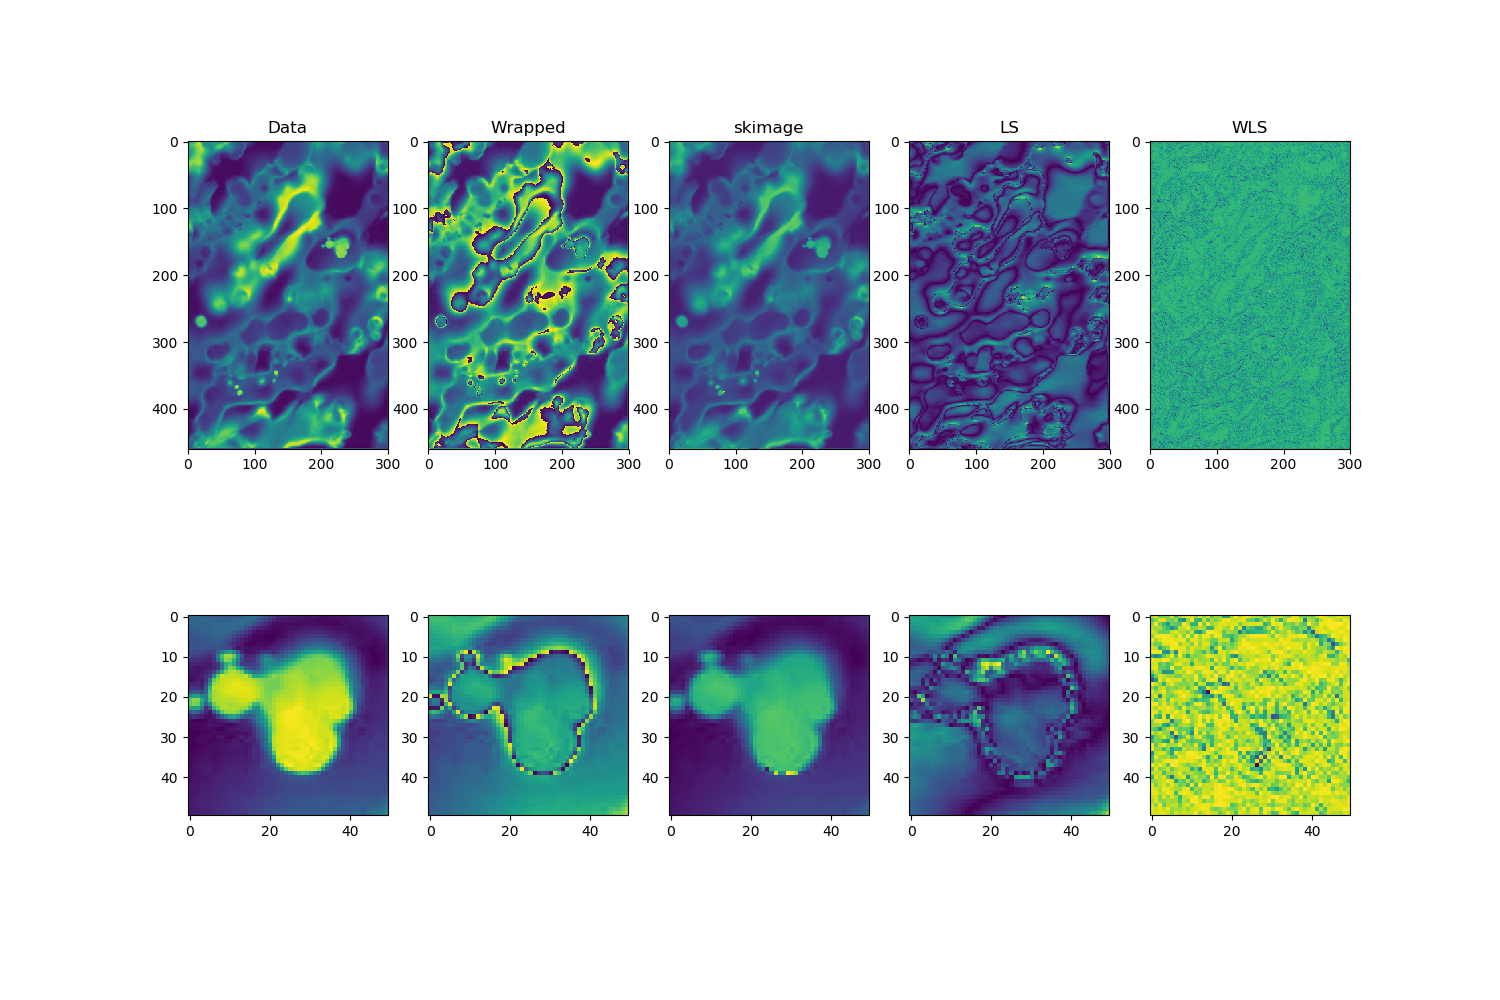

In [16]:
data = np.load('corn_fluorescence.npy')
data = (data-np.min(data))/np.max(data)
wrap_factor = 4*np.pi
data = wrap_factor*data - np.pi
                        
wrapped_data = wrap(data)

LS = unwrap_LS(wrapped_data)
WLS,residuesWLS = min_Lp_norm_phase_unwrap(wrapped_data)
skimage = unwrap_phase(wrapped_data)

figure, ax = plt.subplots(2,5,figsize=(15,10))
ax[0,0].imshow(data), ax[0,0].set_title('Data')
ax[0,1].imshow(wrapped_data),  ax[0,1].set_title("Wrapped")
ax[0,2].imshow(skimage), ax[0,2].set_title("skimage")
ax[0,3].imshow(LS), ax[0,3].set_title("LS")
ax[0,4].imshow(WLS), ax[0,4].set_title("WLS")

ax[1,0].imshow(data[135:185,200:250])
ax[1,1].imshow(wrapped_data[135:185,200:250])
ax[1,2].imshow(skimage[135:185,200:250])
ax[1,3].imshow(LS[135:185,200:250])
ax[1,4].imshow(WLS[135:185,200:250])
